In [221]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px
import tensorflow as tf

In [222]:
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , GRU , Embedding 
from tensorflow.keras.optimizers import SGD , Adam 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint


In [223]:
sentiment_data = pd.read_csv("Data/sentiment_text.csv")

In [224]:
sentiment_data.head()

Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4

In [225]:
sentiment_data.duplicated().sum()

0

In [226]:
sentiment_data.isna().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

* **Drop Unnamed Column**

In [227]:
sentiment_data = sentiment_data.drop("Unnamed: 0" , axis=1)

* Six Category: sad (0), joy (1), love (2), fury (3), fear  (4) and suprise (5).

In [229]:
map_sentiment = {
    0 : "Sad" , 
    1 : "Joy" , 
    2 : "Love" , 
    3 : "Fury" , 
    4 : "Fear" , 
    5 : "Suprise"
}

sentiment_data["label"] = sentiment_data["label"].map(map_sentiment)

sentiment_data.head()

text label
0      i just feel really helpless and heavy hearted  Fear
1  ive enjoyed being able to slouch about relax a...   Sad
2  i gave up my internship with the dmrg and am f...  Fear
3                         i dont know i feel so lost   Sad
4  i am a kindergarten teacher and i am thoroughl...  Fear

In [230]:
fig = px.pie(
    sentiment_data , 
    names= "label" , 
    title = "Sentiment" , 
    color_discrete_sequence= px.colors.qualitative.Bold_r
)

fig.update_traces(
    textinfo="label + percent"
    )

fig.update_layout(
    width = 900 ,
    height = 700
)

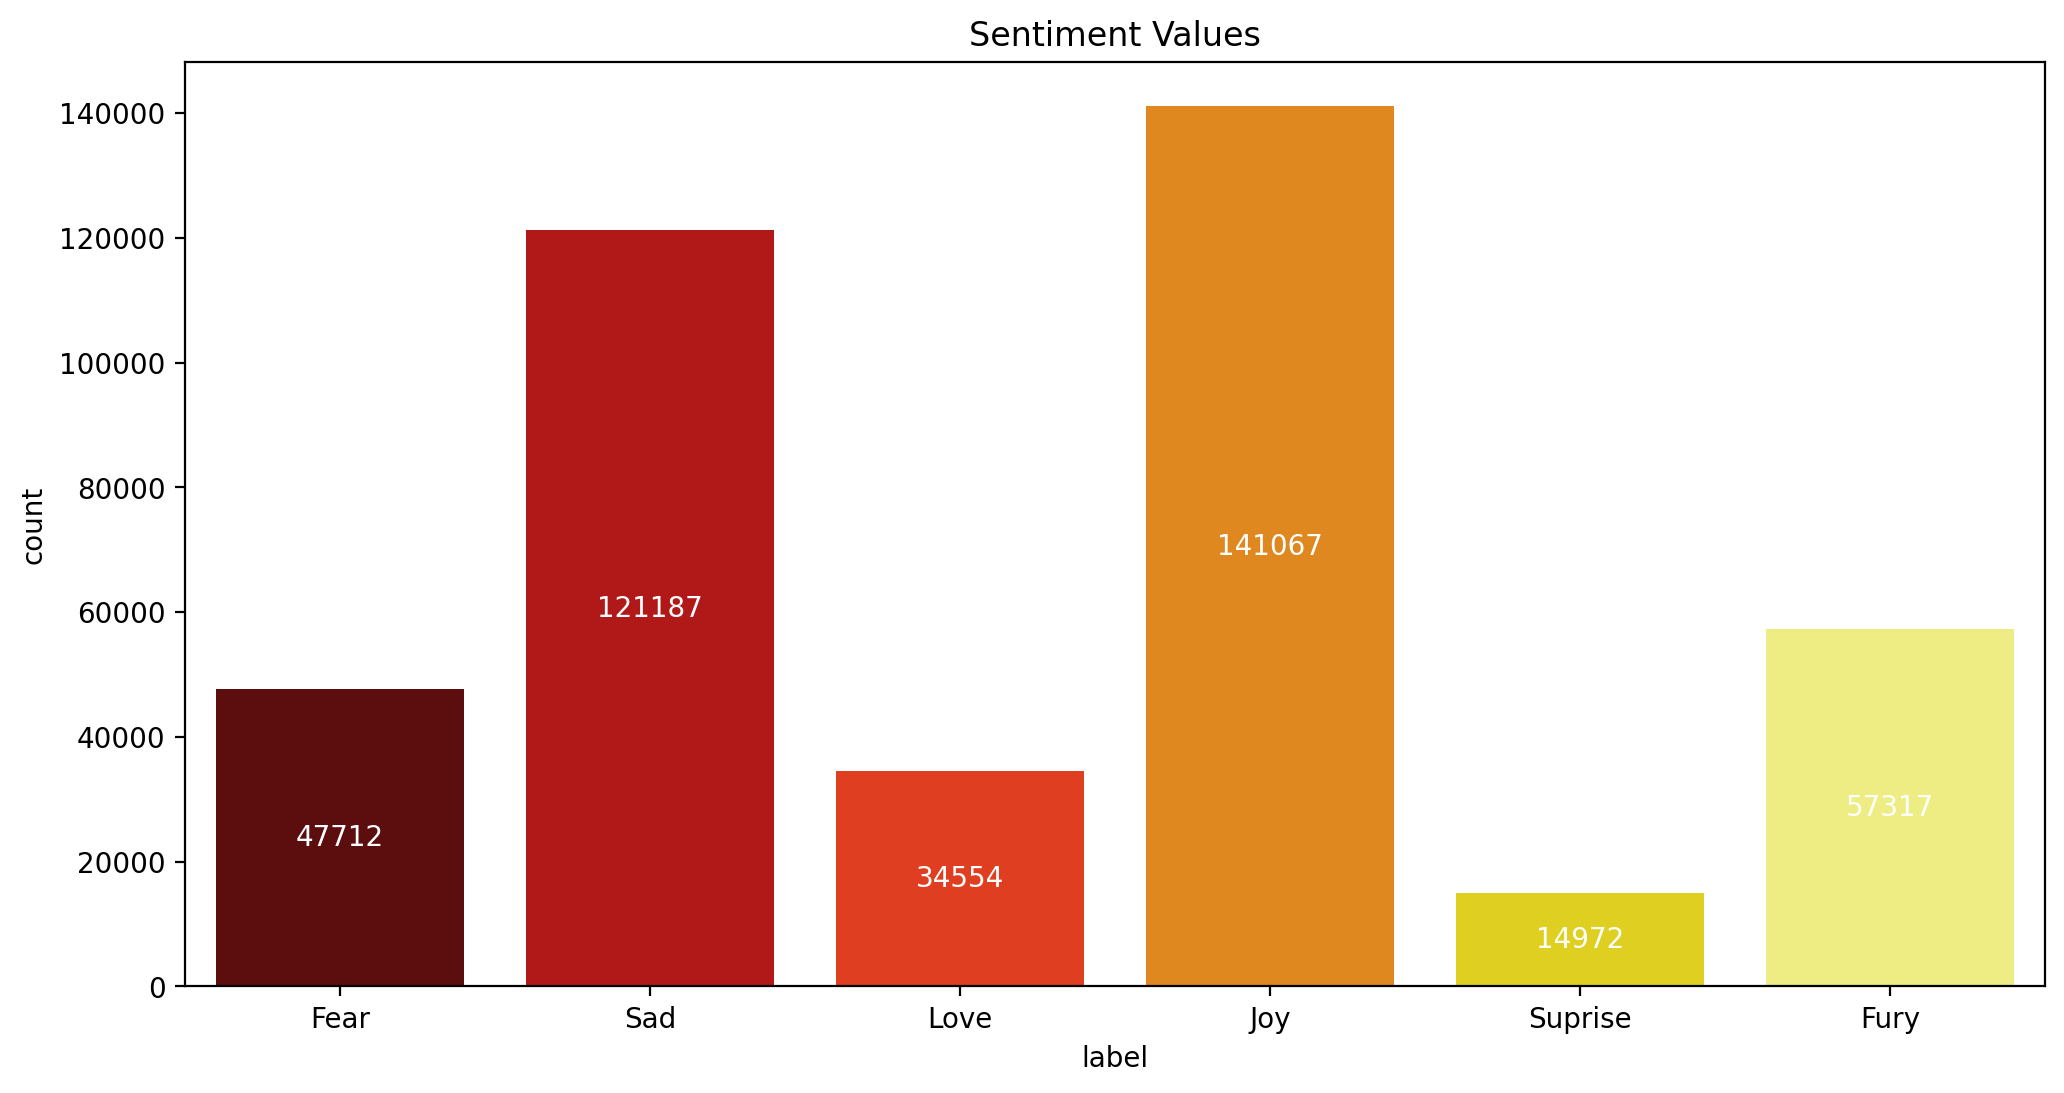

In [231]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(12,6) , dpi=200)
ax = sns.countplot(x = "label" , data=sentiment_data , palette="hot")
for i in ax.containers:
    ax.bar_label(i , label_type="center" , color = "white")
plt.title("Sentiment Values")
plt.show()

* **Cloud Word**

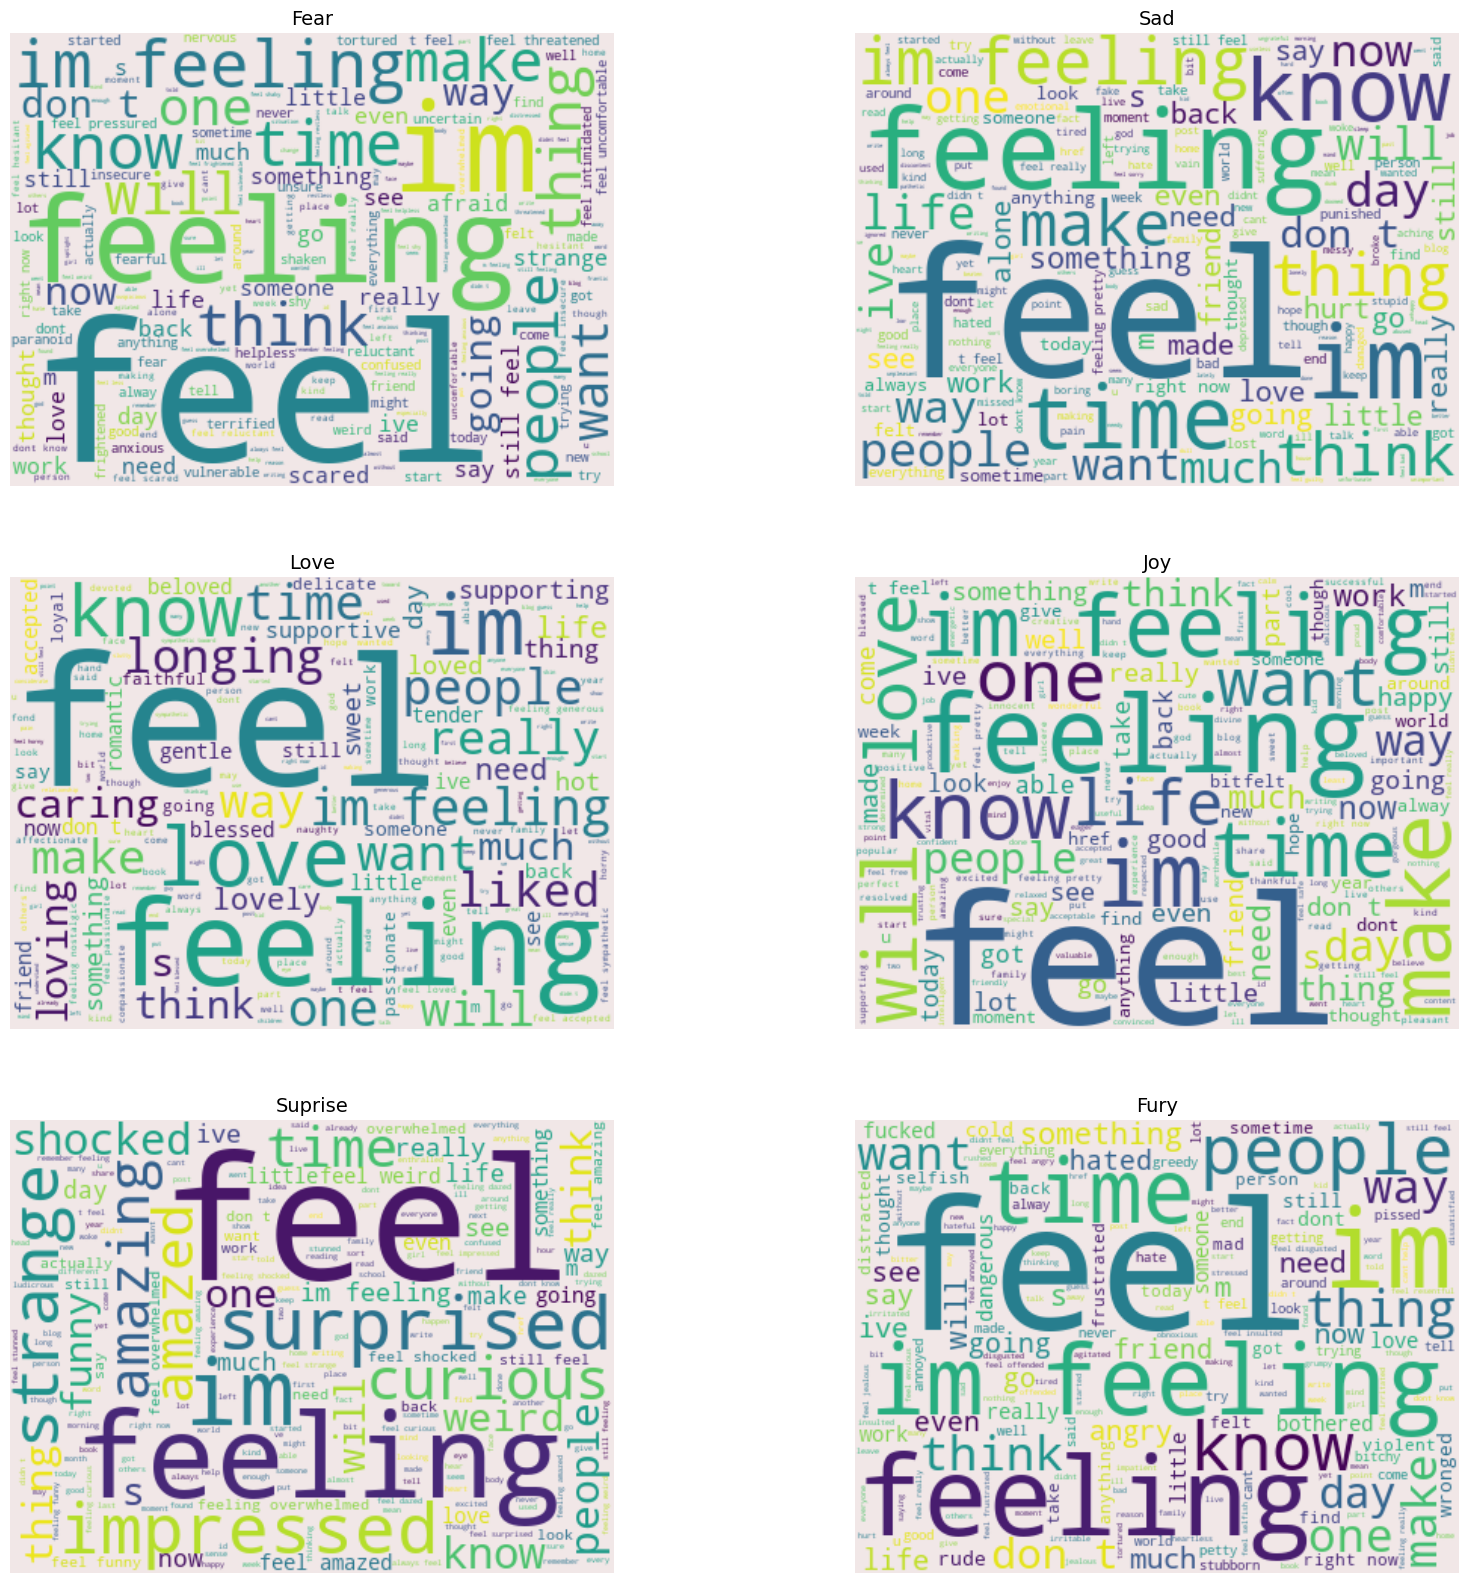

In [232]:
from wordcloud import WordCloud

category = sentiment_data["label"].unique()

fig , ax = plt.subplots(3,2 ,figsize = (20,20))

for i , cat in enumerate(category):
    text = " ".join(sentiment_data[sentiment_data["label"] == cat]["text"])
    wordcloud = WordCloud(width=400 , height=300 , background_color="#F1E7E7").generate(text)

    row, col = divmod(i, 2)  
    ax[row, col].imshow(wordcloud, interpolation="bilinear")
    ax[row, col].axis("off")
    ax[row, col].set_title(f"{cat}" , size = 14)  

plt.show()

* **StopWords**

In [233]:
import nltk
from nltk.corpus import stopwords

wordstop = stopwords.words("english")
sentiment_data["text"] = sentiment_data["text"].apply(
    lambda x : " ".join([word for word in x.split() if word not in wordstop])
)

* **Clean Word**

In [234]:
import re

sentiment_data["text"] = sentiment_data["text"].apply(
    lambda x : re.sub(r"[^a-z\s]", "" , x.lower())
)

In [235]:
map_sentiment = {
    "Sad" : 0 , 
    "Joy" : 1 , 
    "Love" :2 , 
    "Fury" : 3  , 
    "Fear" : 4 , 
    "Suprise" : 5
}

sentiment_data["label"] = sentiment_data["label"].map(map_sentiment)

sentiment_data.head()

text  label
0                 feel really helpless heavy hearted      4
1  ive enjoyed able slouch relax unwind frankly n...      0
2            gave internship dmrg feeling distraught      4
3                                dont know feel lost      0
4  kindergarten teacher thoroughly weary job take...      4

* **Train Test Split**

In [236]:
X = sentiment_data["text"]
y = sentiment_data["label"]

In [237]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(
    X , y , 
    random_state=42 ,
      train_size=0.8 ,
        stratify=sentiment_data["label"])

In [238]:
print(X_train[200])
print(y_train[200])

writing look feel wonderfully privileged known many like unlike extreme situations
1


* **Tokenizer**

In [239]:
tokenizer = Tokenizer(
    num_words = 40_000 , 
    lower = True , 
    oov_token = ""
)

In [240]:
tokenizer.fit_on_texts(X_train)

In [241]:
len(tokenizer.word_index)

67650

* **Text To Sequences**

In [242]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [243]:
X_test[:1]

375721    feel blessed able spend one semester teaching ...
Name: text, dtype: object

In [244]:
X_test_sequences[0]

[2, 161, 92, 389, 14, 1941, 1247, 661, 1592, 3445]

* **Padding**

In [245]:

num_toknes = [len(tokens) for tokens in X_test_sequences + X_train_sequences]

num_tokens = np.array(num_toknes)

In [246]:
print(np.max(num_tokens))
print(np.min(num_tokens))
print(np.mean(num_tokens))


79
0
9.356388657634552


In [247]:
# find actual pad_sequences size 
max_tokens = np.mean(num_tokens) + (2* np.std(num_tokens))
max_tokens = int(max_tokens)
max_tokens

19

In [248]:
np.sum(num_tokens < max_tokens) / len(num_tokens) 

0.934272052666809

In [249]:
X_train_pad = pad_sequences(
    X_train_sequences , 
    maxlen = max_tokens
)

X_test_pad = pad_sequences(
    X_test_sequences , 
    maxlen = max_tokens
)

In [250]:
X_train_pad 

array([[   0,    0,    0, ...,  464, 6359,   52],
       [   0,    0,    0, ...,   13,    2,  686],
       [   0,    0,    0, ..., 1832,  688, 3492],
       ...,
       [   0,    0,    0, ...,    3,  278,  198],
       [   0,    0,    0, ...,    2,  411,  207],
       [   0,    0,    0, ...,    4,  630, 2570]], dtype=int32)

In [251]:
X_test_pad

array([[    0,     0,     0, ...,   661,  1592,  3445],
       [    0,     0,     6, ...,   866,     1,  4288],
       [    0,     0,     0, ...,  2439,   601,  1384],
       ...,
       [    0,     0,     0, ...,     3,   566,    30],
       [    0,     0,     0, ..., 11198,   299,     1],
       [    0,     0,     0, ...,  1134,  1380,     1]], dtype=int32)

In [252]:
print(X_test_pad.shape)
print(X_train_pad.shape)

(83362, 19)
(333447, 19)


* **GRU Model**

In [253]:
model_gru = Sequential()

In [254]:
model_gru.add(
    Embedding(
        40_000 , 
        100 , 
        input_length = max_tokens 
        
    )
)

In [255]:
model_gru.add(
    GRU(
        32 , 
        use_bias = True , 
        return_sequences = True ,
        dropout = 0.1    
    )
)

model_gru.add(BatchNormalization())


model_gru.add(
    GRU(
        16 , 
        use_bias = True , 
        return_sequences = True , 
        dropout = 0.1
    )
)

model_gru.add(BatchNormalization())

model_gru.add(
    GRU(
        8 , 
        use_bias = True , 
        return_sequences = False
    )
)

model_gru.add(
    Dense(6 , 
          activation = "softmax"  )
)


In [256]:
model_gru.compile(
    optimizer = "adam" , 
    loss="sparse_categorical_crossentropy",    
    metrics = ["accuracy"]
)

In [258]:
model_gru.build(input_shape=(None, max_tokens)) 
model_gru.summary()  


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 19, 100)        │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 19, 32)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 19, 16)         │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 19, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,016,134 (15.32 MB)

 Trainable params: 4,016,038 (15.32 MB)

 Non-trainable params: 96 (384.00 B)

* **Callbacks**

In [260]:
early_stopper = EarlyStopping(
    monitor = "val_loss" , 
    verbose = 1 , 
    patience = 5 
)

model_checkpoint = ModelCheckpoint(
    monitor = "val_los" , 
    verbose = 1 , 
    save_best_only = True , 
    filepath = "gru_model.keras"

)

In [261]:
paramater_callbacks = [early_stopper , model_checkpoint]

In [262]:
history = model_gru.fit(
    X_train_pad , 
    y_train , 
    batch_size = 128 , 
    validation_split = 0.2 , 
    epochs = 10 , 
    verbose = 1 , 
    callbacks = paramater_callbacks
)

Epoch 1/10
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 60s 28ms/step - accuracy: 0.8161 - loss: 0.5365 - val_accuracy: 0.9298 - val_loss: 0.1283
Epoch 2/10
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 56s 27ms/step - accuracy: 0.9357 - loss: 0.1197 - val_accuracy: 0.9308 - val_loss: 0.1210
Epoch 3/10
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 56s 27ms/step - accuracy: 0.9395 - loss: 0.1029 - val_accuracy: 0.9326 - val_loss: 0.1238
Epoch 4/10
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - accuracy: 0.9411 - loss: 0.0960 - val_accuracy: 0.9293 - val_loss: 0.1338
Epoch 5/10
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 57s 27ms/step - accuracy: 0.9450 - loss: 0.0888 - val_accuracy: 0.9305 - val_loss: 0.1380
Epoch 6/10
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 59s 28ms/step - accuracy: 0.9434 - loss: 0.0859 - val_accuracy: 0.9298 - val_loss: 0.1456
Epoch 7/10
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - accuracy: 0.9456 - loss: 0.0830 - val_accuracy: 0.9304 - val_loss: 0.1504
Epoch 7: early stopping


* **Evaluate** 

In [263]:
model_gru.evaluate(X_test_pad , y_test)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9292 - loss: 0.1439


[0.14677694439888, 0.9289724230766296]

In [276]:
predict = model_gru.predict(X_test_pad[0:1000])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [277]:
predict

array([[7.7265679e-05, 5.1668537e-01, 4.8160601e-01, 3.6759360e-05,
        1.4206116e-03, 1.7410403e-04],
       [8.0310958e-05, 9.7834109e-04, 9.9877143e-01, 2.8702190e-05,
        3.9656908e-05, 1.0155848e-04],
       [3.4992074e-04, 4.9580445e-05, 1.0164528e-04, 3.6327782e-04,
        9.9875695e-01, 3.7865882e-04],
       ...,
       [6.5126751e-06, 9.9976611e-01, 1.1453654e-04, 4.8274345e-05,
        1.0090463e-05, 5.4400003e-05],
       [9.9980593e-01, 9.0973599e-06, 3.8565381e-06, 5.5650336e-05,
        1.1701864e-04, 8.5307311e-06],
       [5.8848382e-06, 9.9976492e-01, 1.2067035e-04, 4.5789726e-05,
        9.6090753e-06, 5.3100706e-05]], dtype=float32)

In [278]:
predictions = np.argmax(predict, axis=1)
predictions

array([1, 2, 4, 1, 4, 3, 4, 0, 0, 1, 3, 1, 1, 1, 1, 1, 4, 1, 0, 1, 1, 1,
       0, 3, 3, 3, 1, 1, 0, 0, 1, 4, 4, 3, 0, 0, 4, 1, 1, 1, 4, 0, 2, 1,
       0, 1, 3, 1, 1, 0, 0, 1, 5, 1, 1, 3, 4, 0, 1, 4, 4, 4, 1, 3, 3, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 5, 1, 1, 3, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 3, 1, 0,
       3, 0, 0, 1, 3, 1, 0, 4, 3, 3, 3, 0, 3, 2, 1, 3, 0, 4, 0, 3, 3, 0,
       1, 2, 2, 0, 3, 0, 3, 3, 1, 1, 5, 1, 0, 1, 0, 2, 2, 1, 4, 1, 1, 1,
       0, 0, 1, 1, 0, 3, 5, 1, 1, 0, 1, 1, 1, 3, 0, 1, 2, 3, 0, 0, 0, 1,
       1, 4, 3, 1, 3, 0, 1, 1, 0, 2, 1, 4, 1, 0, 0, 0, 3, 4, 0, 1, 3, 4,
       1, 1, 2, 1, 0, 0, 4, 3, 3, 3, 3, 0, 1, 0, 3, 0, 3, 1, 0, 4, 1, 3,
       0, 1, 0, 1, 3, 5, 1, 3, 1, 0, 1, 0, 3, 1, 1, 4, 2, 0, 0, 0, 1, 5,
       4, 0, 2, 1, 2, 1, 1, 1, 5, 0, 4, 1, 0, 1, 1, 3, 0, 3, 3, 5, 0, 4,
       0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 3, 3, 1, 0, 4, 1, 0, 1, 3, 1, 0, 0,
       3, 0, 1, 1, 5, 1, 4, 0, 2, 3, 1, 5, 0, 1, 0,

In [295]:
from sklearn.metrics import ConfusionMatrixDisplay , confusion_matrix 

<Figure size 1000x1000 with 0 Axes>

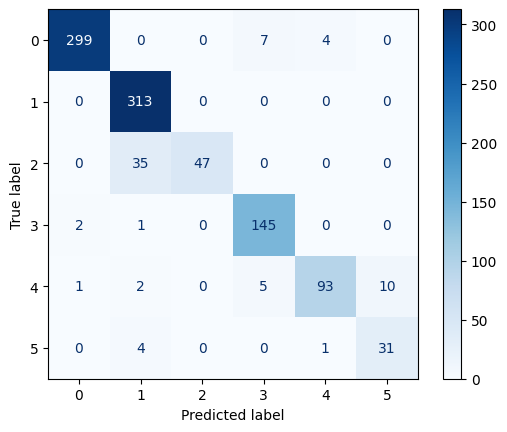

In [294]:
cm = confusion_matrix(y_test[0:1000], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Blues")

plt.show()
